# Real-time Control of Quantum Computers with OpenQASM3, Qiskit, and IBM Quantum Services
#### @Quantom  & @Micheal Healy & @Hoss Ajallooiean - Qiskit Slack
#### @taalexander & @mbhealy & @katetsu - Github

Join us on the Qiskit Slack channel [#ieee-tutorial-openqasm3](https://qiskit.slack.com/archives/C02HQLDS3D3)

## Preamble

In [ ]:
import os
from typing import Any, List, Dict, Union

import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info as qi
from qiskit.providers.ibmq import RunnerResult
from qiskit.result import marginal_counts
import qiskit.tools.jupyter

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


## Running OpenQASM3 through Qiskit

*note*: Before running this notebook make sure to the follow the steps in the [Hello OpenQASM3](./Hello-OpenQASM3.ipynb).

In the [Hello OpenQASM3](./Hello-OpenQASM3.ipynb) you would have run an OpenQASM3 program at the end.

This is done in several steps.

### First we load our backend

In [77]:
hub = 'ibm-q-community'
group = 'ieee-session'
project = 'event-2021'
backend_name = 'ibm_perth'

In [78]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend(backend_name)

ibmqfactory.load_account:WARNING:2021-10-20 11:47:17,041: Credentials are already in use. The existing account in the session will be replaced.


In [79]:
import qiskit.tools.jupyter
backend

<IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q-community', group='ieee-session', project='event-2021')>

## Next we write a Qiskit Circuit as normal

By integrating QASM3 with the QuantumCircuit interface we gain access to the extensive suite of Qiskit algorithms and applications.


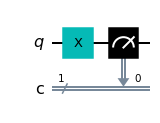

In [85]:
from qiskit import QuantumCircuit

# Fill in Readout test and draw

In [ ]:
from qiskit import QuantumCircuit

qc_prep_excited = QuantumCircuit(1, 1)
qc_prep_excited.x(0)
qc_prep_excited.measure(0, 0)
qc_prep_excited.draw(output="mpl", idle_wires=False)

# We then transpile the circuit to target it to our backend

In [86]:
qubit = 3
shots = 1000

In [87]:
from qiskit import transpile

# Transpile for qubit and draw

ancilla_0 -> 0 ────────
                       
ancilla_1 -> 1 ────────
                       
ancilla_2 -> 2 ────────
               ┌───┐┌─┐
      q_0 -> 3 ┤ X ├┤M├
               └───┘└╥┘
ancilla_3 -> 4 ──────╫─
                     ║ 
ancilla_4 -> 5 ──────╫─
                     ║ 
ancilla_5 -> 6 ──────╫─
                     ║ 
          c: 1/══════╩═
                     0

In [ ]:
from qiskit import transpile

qc_prep_excited_transpiled = transpile(qc_prep_excited, backend, initial_layout=[qubit])

qc_prep_excited_transpiled.draw(output="mpl", idle_wires=False)

# We then imported a routine and ran it

In [88]:
from run_openqasm3 import run_openqasm3

# Run the circuit / QASM3

======circuit-275======
=======QASM3======
OPENQASM 3;
bit[1] c;
x $3;
c[0] = measure $3;

                       
ancilla_0 -> 0 ────────
                       
ancilla_1 -> 1 ────────
                       
ancilla_2 -> 2 ────────
               ┌───┐┌─┐
      q_0 -> 3 ┤ X ├┤M├
               └───┘└╥┘
ancilla_3 -> 4 ──────╫─
                     ║ 
ancilla_4 -> 5 ──────╫─
                     ║ 
ancilla_5 -> 6 ──────╫─
                     ║ 
          c: 1/══════╩═
                     0 
Running: c5o2pltrd6ls96t2rn4g
=======circuit-275=======
{'0': 20, '1': 980}


In [ ]:
from run_openqasm3 import run_openqasm3

job = run_openqasm3(qc_prep_excited_transpiled, backend, verbose=True)

# What is actually going on underneath the hood?

We're submitting circuit jobs to a QASM3 program in the [Qiskit Runtime](https://quantum-computing.ibm.com/lab/docs/iql/runtime/).

![Qiskit Runtime](https://iqx-docs.quantum-computing.ibm.com/_images/qiskit-runtime1.gif)

### Submitting directly to the runtime

First we build our program arguments and options

In [89]:
runtime_params = {
    'circuits': [qc_readout],
}

options = {'backend_name': backend.name()}

### Then we submit to the `circuit-runner-qasm3` Runtime.


In [90]:
from qiskit.providers.ibmq import RunnerResult

prep_excited_job = provider.runtime.run(
    program_id="circuit-runner-qasm3",
    options=options,
    inputs=runtime_params,
    image="qiskit-program-qasm3:latest",
    result_decoder=RunnerResult,
)

The runtime returns us a job handle.

Note that the `RunnerResult` decoder we've passed to the runtime handles decoding of our results to the standard Qiskit result format. In general runtimes can return any JSON output provided an appropriate decoder is available.

Fetching the result is just like a normal Qiskit Qobj job.

In [91]:
prep_excited_result = prep_excited_job.result()
print(prep_excited_result.get_counts())

{'0': 23, '1': 977}


### We can also submit a QASM3 string directly to the runtime

This is useful for the cases where the `QuantumCircuit` does not yet support all of the semantics of OpenQASM3.

We can get the QASM3 for our circuit from Qiskit.

*Note*: This is not currently released and is part of the Qiskit Terra `main` branch.

In [92]:
try:
    from qiskit import qasm3
except ImportError:
    print("You likely do not have the main branch of Qiskit installed. Please install it to run this code")
    raise
    


In [94]:
basis_gates = backend.configuration().basis_gates

def dump_qasm3(circuit, backend=backend):
    return qasm3.Exporter(includes=[], basis_gates=basis_gates).dumps(circuit)

excited_prep_source_string = dump_qasm3(qc_readout)
print(excited_prep_source_string)

OPENQASM 3;
bit[1] c;
x $3;
c[0] = measure $3;



## We may then submit to the runtime

In [95]:
runtime_params = {
    'circuits': [excited_prep_source_string],
}

options = {'backend_name': backend.name()}


prep_excited_job_source_str = provider.runtime.run(
    program_id="circuit-runner-qasm3",
    options=options,
    inputs=runtime_params,
    image="qiskit-program-qasm3:latest",
    result_decoder=RunnerResult,
)

In [96]:
print(prep_excited_job_source_str.result().get_counts())

{'0': 27, '1': 973}


### Why use the runtime?

The runtime execution is colocated with the QPU through a low-latency path. In the future this will allow rapid execution of parameterized programs without recompilation or hardware reloading.

```qasm

OPENQASM 3;

input angle theta;

bit[1] c;
rz(theta) $0;
x $0;
c[0] = measure $0;
```

This is an important step towards and accelerator model in Qiskit and IBM hardware for practical quantum computations.

## A Hierarchy of latencies

<img src="./figs/qasm3_hierarchies.png" alt="drawing" style="width:1000px;"/>


This is an important step towards and accelerator model in Qiskit and IBM hardware for practical quantum computations.

For this demo latencies are high, but this is because we have not enabled compilation-unit batching of circuits.

## Let's run some "Real Time" Compute

In 2020 IBM introduced some of the first features of real-time compute, multiple measurements and conditional resets.

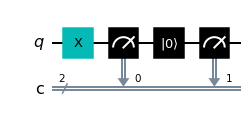

In [100]:
qc_real_time = QuantumCircuit(1, 2)

# Program a builtin reset test circuit named job real time and draw


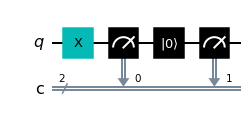

In [117]:
qc_real_time = QuantumCircuit(1, 2)
qc_real_time.x(0)
qc_real_time.measure(0, 0)
qc_real_time.reset(0)
qc_real_time.measure(0, 1)

qc_real_time.draw(output="mpl", idle_wires=False)

In [118]:
# Run the reset job and check the results
real_time_job = backend.run(transpile(qc_real_time, backend, initial_layout=[qubit]))
print(real_time_job.job_id())

6170354a9c88ce4edab0e9b1


In [102]:
print(f" Our reset counts were: {real_time_job.result().get_counts(0)}")

 Our reset counts were: {'00': 14, '01': 991, '11': 19}


In [ ]:
job_real_time = backend.run(qc_real_time)
print(f"Job id: {job_real_time.job_id()}")
result_real_time = job_real_time.result() 
print(f"Reset results: {result_real_time.get_counts(0)}")


# Writing Conditional Reset Directly
However, we wanted to put more expressive semantics in our user's hands to explore quantum error correction and other applications requiring real-time compute.

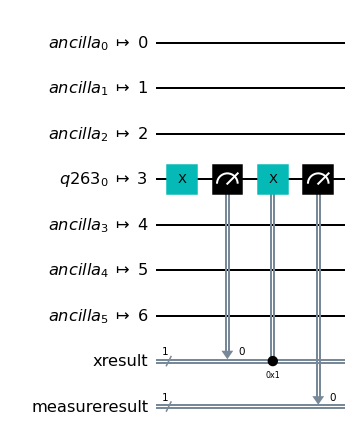

In [107]:
from qiskit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
crx = ClassicalRegister(1, name="xresult")
crm = ClassicalRegister(1, name="measureresult")
qc_reset = QuantumCircuit(qr, crx, crm, name="Reset")

# Program a reset directly using control flow and draw


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister

qr = QuantumRegister(1)
crx = ClassicalRegister(1, name="xresult")
crm = ClassicalRegister(1, name="measureresult")
qc_reset = QuantumCircuit(qr, crx, crm, name="Reset")
qc_reset.x(0)
qc_reset.measure(0, crx)
qc_reset.x(0).c_if(crx, 1)
qc_reset.measure(0, crm)
 
qc_reset = transpile(qc_reset, backend, initial_layout=[1])
qc_reset.draw(output="mpl", idle_wires=False)

### Alternatively we can write as a QASM3 program

In [108]:
print(dump_qasm3(qc_reset))

OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $3;
xresult[0] = measure $3;
if (xresult == 1) {
x $3;
}
measureresult[0] = measure $3;



### Run the program

In [119]:
reset_job = run_openqasm3(qc_reset, backend, verbose=True)

======Reset======
=======QASM3======
OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $3;
xresult[0] = measure $3;
if (xresult == 1) {
x $3;
}
measureresult[0] = measure $3;

                                   
  ancilla_0 -> 0 ──────────────────
                                   
  ancilla_1 -> 1 ──────────────────
                                   
  ancilla_2 -> 2 ──────────────────
                 ┌───┐┌─┐ ┌───┐ ┌─┐
     q263_0 -> 3 ┤ X ├┤M├─┤ X ├─┤M├
                 └───┘└╥┘ └─╥─┘ └╥┘
  ancilla_3 -> 4 ──────╫────╫────╫─
                       ║    ║    ║ 
  ancilla_4 -> 5 ──────╫────╫────╫─
                       ║    ║    ║ 
  ancilla_5 -> 6 ──────╫────╫────╫─
                       ║ ┌──╨──┐ ║ 
      xresult: 1/══════╩═╡ 0x1 ╞═╬═
                       0 └─────┘ ║ 
measureresult: 1/════════════════╩═
                                 0 
Running: c5o3aotrd6ls96t2rq30
=======Reset=======
{'0 0': 17, '0 1': 926, '1 1': 57}


## Stack Diagram
<img src="./figs/demo_path.png" alt="drawing" style="width:550px;"/>

### How did we do?

In [124]:

from qiskit.result import marginal_counts

reset_result = reset_job.result()
reset_counts = reset_result.get_counts(0)
mitigated_reset_results = marginal_counts(reset_counts, indices=[1])
print(f"Full counts including reset: {reset_counts}")
print(f"Results from our reset - |0>s prepared {mitigated_reset_results.get('0')}, |1>s prepared {mitigated_reset_results['1']}"
)
      


Full counts including reset: {'0 0': 17, '0 1': 926, '1 1': 57}
Results from our reset - |0>s prepared 943, |1>s prepared 57


### Let's try several rounds of reset

In [126]:
# Program several rounds of reset using QASM3

#print(dump_qasm3(qc_reset))

qubit_init_qasm3 = """

"""

In [120]:
qubit_init_qasm3 = """
    
OPENQASM 3;

bit reset_result0;
bit reset_result1;
bit reset_result2;
bit[1] measureresult;

x $1;
reset_result0 = measure $1;

// three rounds of reset.
if (reset_result0 == 1) {
    x $1;
}

reset_result1 = measure $1;

if (reset_result1 == 1) {
    x $1;
}

reset_result2 = measure $1;

if (reset_result2 == 1) {
    x $1;
}

// Final measurement
measureresult[0] = measure $1;

"""

In [127]:
init_job = run_openqasm3(qubit_init_qasm3, backend, verbose=False)
print(init_job.job_id())
better_reset_result_1s = sum(count for key, count in init_job.result().get_counts(0).items() if (len(key)==4))
print(f"Results from our better reset - |0>s prepared {shots-better_reset_result_1s}, |1>s prepared {better_reset_result_1s} ")


c5o3d7drd6ls96t2rqmg
Results from our better reset - |0>s prepared 996, |1>s prepared 4 


## Teleporting a Quantum State
<img src="./figs/telamon.jpeg" alt="drawing" style="width:700px;"/>

### Prepare the teleportation circuit

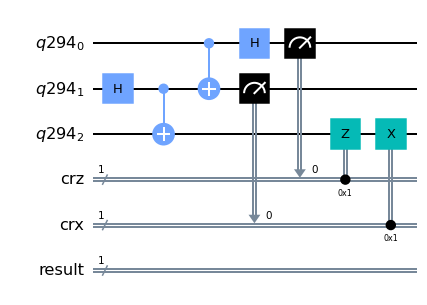

In [128]:
qr = QuantumRegister(3)
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
result = ClassicalRegister(1, name="result")

qc_teleport = QuantumCircuit(qr, crz, crx, result, name="Teleport")

# Apply teleportation circuit
qc_teleport.h(qr[1])
qc_teleport.cx(qr[1], qr[2])
#qc_teleport.barrier(qr)
qc_teleport.cx(qr[0], qr[1])
qc_teleport.h(qr[0])
qc_teleport.measure(qr[0], crz)
qc_teleport.measure(qr[1], crx)
qc_teleport.z(qr[2]).c_if(crz, 1)
qc_teleport.x(qr[2]).c_if(crx, 1)
qc_teleport.draw(output="mpl")

### Prepare the Teleport experiment Circuit

In [129]:
qc_state_prep = QuantumCircuit(1)
qc_state_prep.x(0)

print(qc_state_prep)

target_state_prep = qi.Statevector.from_instruction(qc_state_prep)
print(target_state_prep)

   ┌───┐
q: ┤ X ├
   └───┘
Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


### Compose the state initialization with the teleportation

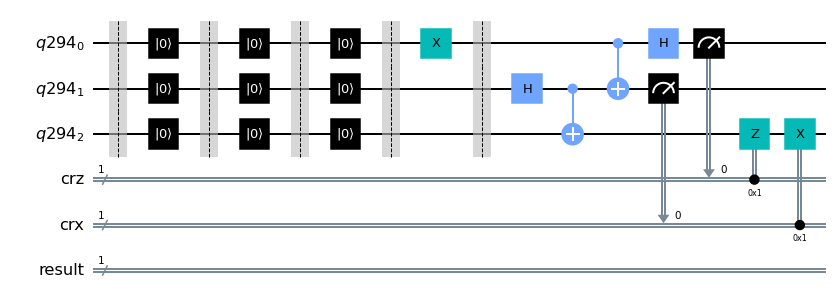

In [130]:
teleport_qubits = [0, 1, 2]

qc_teleport_state = QuantumCircuit(qr, crz, crx, result, name="Teleport Hadamard")

def init(qc, qr):
    qc.barrier(qr)
    qc.reset(qr)
    qc.barrier(qr)
    qc.reset(qr)
    qc.barrier(qr)
    qc.reset(qr)
    qc.barrier(qr)

init(qc_teleport_state, qr)

# Prepare state to teleport
qc_teleport_state.compose(qc_state_prep, [qr[0]], inplace=True)
qc_teleport_state.barrier(qr)

# Compose with teleportation circuit
qc_teleport_state.compose(qc_teleport, inplace=True)

qc_teleport_state.draw(output="mpl")

### Transpile for backend and execute

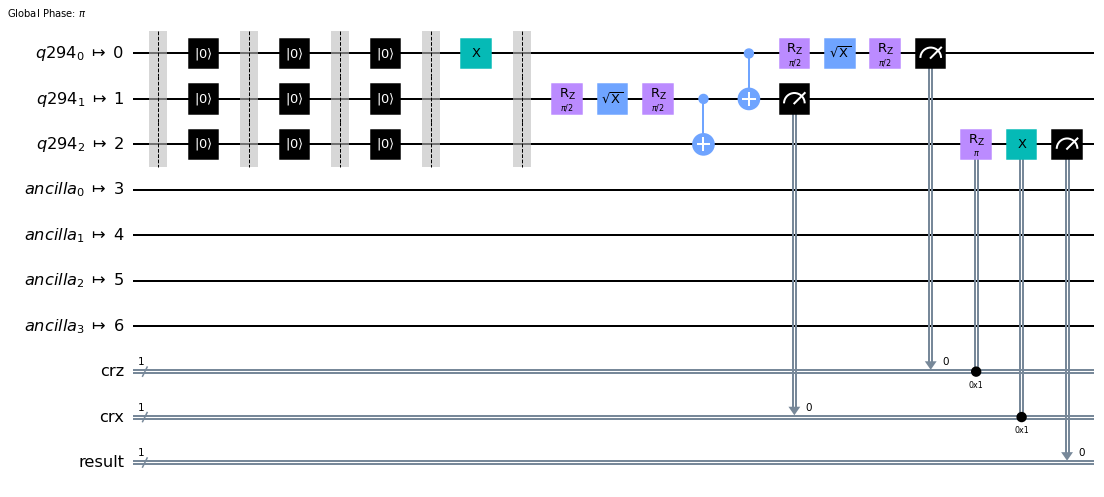

In [131]:
qc_teleport_experiment = qc_teleport_state.copy()
qc_teleport_experiment.measure(qr[2], result)
qc_teleport_experiment = transpile(qc_teleport_experiment, backend, initial_layout=teleport_qubits, optimization_level=3)
qc_teleport_experiment.draw(output="mpl")

## Run our Teleportation Experiment

In [132]:
teleport_job = run_openqasm3(qc_teleport_experiment, backend, verbose=False)
print(teleport_job.job_id())

c5o3fn3rrcfjv06etn30


In [133]:
teleport_result = teleport_job.result()
print(f"All teleportation reults: {teleport_result.get_counts(0)}")

marginal_teleport_counts = marginal_counts(teleport_result.get_counts(0), indices=[2])
print(f"Marginalized teleportation counts: {marginal_teleport_counts}")

All teleportation reults: {'0 0 0': 9, '0 0 1': 140, '0 1 0': 5, '0 1 1': 43, '1 0 0': 12, '1 0 1': 366, '1 1 0': 18, '1 1 1': 407}
Marginalized teleportation counts: {'0': 197, '1': 803}


### Measurement Error Mitigation and Tomography
As integration is down through Qiskit. We still get to use all of Qiskit's QCVV infrastructure.

In [134]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.visualization import plot_state_city, plot_state_paulivec

### Measurement Error Mitigation

**Measurement Error Mitigation**: The measurement calibration is used to mitigate measurement errors. The main idea is to prepare all 2𝑛 basis input states and compute the probability of measuring counts in the other basis states. From these calibrations, it is possible to correct the average results of another experiment of interest.

Next we'll use measurement error mitigation to correct the results of our final measurements.

In [135]:
meas_calibs, state_labels = complete_meas_cal(qr=[qr[2]], circlabel='mcal')
meas_calibs = transpile(meas_calibs, backend, initial_layout={qr[2]: teleport_qubits[-1]})

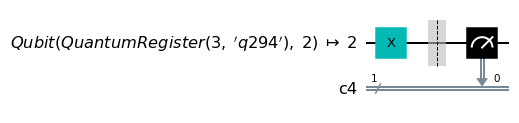

In [136]:
meas_calibs[1].draw(idle_wires=False, output="mpl")

### Run mitigation circuits and extract results

In [137]:
meas_calib_job = run_openqasm3(meas_calibs, backend, verbose=False)
print(f"Job id: {meas_calib_job.job_id()}")

Job id: c5o3h32kh8krlc7cs0tg


In [138]:
meas_calib_result = meas_calib_job.result()

In [139]:
meas_fitter = CompleteMeasFitter(meas_calib_result, state_labels, circlabel='mcal')
meas_fitter.cal_matrix

array([[0.992, 0.015],
       [0.008, 0.985]])

In [140]:
meas_filter = meas_fitter.filter
mitigated_teleport_counts = meas_filter.apply(marginal_teleport_counts)

print(f"Unmitigated teleportation counts {marginal_teleport_counts}")
print(f"Mitigated teleportation counts {mitigated_teleport_counts}")

Unmitigated teleportation counts {'0': 197, '1': 803}
Mitigated teleportation counts {'0': 186.28439140039004, '1': 813.7156085996099}


### Performing State Tomography

**Quantum state tomography**: Given a state-preparation circuit that prepares a system in a state, reconstruct a description of the density matrix 𝜌 of the actual state obtained in the system.


Next we'll use Qiskit Ignis to apply state tomography to our teleported qubit to verify that we teleported a coherent quantum state.

In [141]:
def build_state_tomo_circuits(qc_prep, qr, clbits, tomo_qubits, layout):
    qst_tomography_circuits = state_tomography_circuits(QuantumCircuit(qr), tomo_qubits)
    
    tomography_circuits = []
    for tomo_circuit in qst_tomography_circuits:
        tomo_circ = qc_prep.compose(tomo_circuit, clbits=clbits)
        tomo_circ.name = tomo_circuit.name
        tomography_circuits.append(tomo_circ)
        
    return transpile(tomography_circuits, backend, initial_layout=layout)

In [142]:
qt_qst_tomography_circuits = build_state_tomo_circuits(qc_teleport_state, qr, [result[0]], [qr[2]], teleport_qubits)


### Run QST Teleportation

In [143]:
teleport_qst_jobs = run_openqasm3(qt_qst_tomography_circuits, backend, verbose=False)

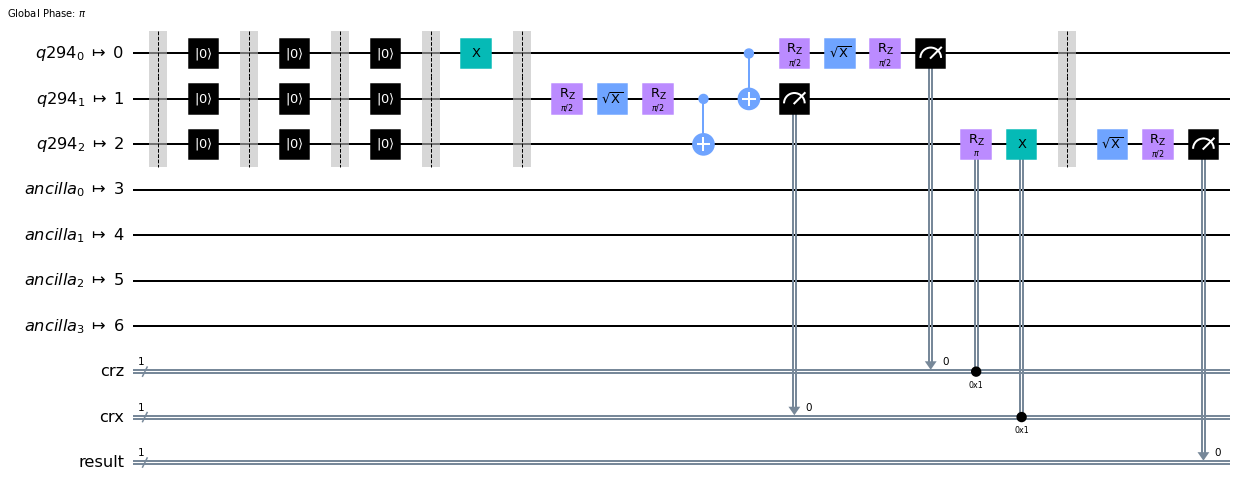

In [144]:
qt_qst_tomography_circuits[1].draw(output="mpl")

### Fit QST Results

In [145]:
teleport_qst_result = teleport_qst_jobs.result()
marginal_teleport_qst_result = marginal_counts(teleport_qst_result, indices=[2])
mitigated_qst_results = meas_filter.apply(marginal_teleport_qst_result)

In [146]:
qt_qst_tomo_fitter = StateTomographyFitter(mitigated_qst_results, qt_qst_tomography_circuits)

In [147]:
qt_qst_rho_fit = qt_qst_tomo_fitter.fit(method='lstsq')
qt_qst_F = qi.state_fidelity(qt_qst_rho_fit, target_state_prep)
print('State Fidelity: F = {:.5f}'.format(qt_qst_F))

State Fidelity: F = 0.80757


### Pauli Vector Plot of the teleported density matrix

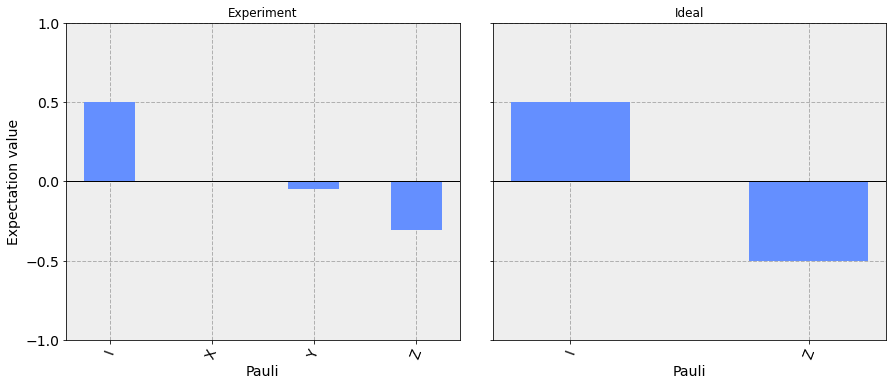

In [148]:
fig, axes = plt.subplots(1, 2, sharey=True)
plot_state_paulivec(qt_qst_rho_fit, ax=axes[0]);
plot_state_paulivec(qi.DensityMatrix.from_instruction(qc_state_prep), ax=axes[1])
axes[1].set_ylabel(None);
axes[0].set_title("Experiment")
axes[1].set_title("Ideal")
plt.tight_layout()
fig.set_size_inches(14, 6)

In [ ]:
plot_state_city(qt_qst_rho_fit, title="Experiment");

In [ ]:
plot_state_city(qi.DensityMatrix.from_instruction(qc_state_prep), title="Ideal");

## Questions and Exercise

That concludes the presentation section of this tutorial session. We now invite you to try running OpenQASM3 yourself on IBM hardware by completing the [exercise here](./OpenQASM3-Exercise-IPE.ipynb).

Feel free to ask any questions you may have and we will do our best to answer them.
